# RNNs: Toy pipeline for variable length sequences

* **Fact**:  In Machine Learning data has to be **first** divided into _training_, _validation_ and _testing_ sets, before cleaning and scaling, so you perform transformations on data unknown for the model (_validation_ and _testing_ sets) with the recipe elaborated based only on your _training_ data.  
* **Positive aspect**: It can be easily done with typical _input vector-output vector_ representation of data-taget. You can take care of it utilizing scikit-learn's pipeline utilities <a href="http://scikit-learn.org/stable/modules/pipeline.html">[1]</a><a href="https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb">[2]</a>.  
* **Negative aspect**: Input data in the form of variable length sequences (which you can find when utilizing RNNs) makes it little bit trickier to perform correct sampling into specific sets and further transformation processes.
* **Task**: We will take a look how the thing can be done in pretty straightforward way.

**Uses:** pandas, numpy, scikit-learn, matplotlib  

Comming soon: images to clarify the concept

---
Ok! Let's add necessary imports and start our toy pipeline processes.  

In [1]:
import os
from enum import Enum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Now, let's read our data from a specific folder into pandas DataFrames (DFs). 

In [2]:
_base_file_name = 'FEATtoy'  #--- base for filenames (data as FEATures, toy example)   
_path = 'data/'
_extension = '.csv'
_delimiter = ','

seqTa = pd.read_csv(_path+'dT'+_base_file_name+_extension, delimiter=_delimiter, header=None)
seqLe = pd.read_csv(_path+'dL'+_base_file_name+_extension, delimiter=_delimiter, header=None)
seqTS = pd.read_csv(_path+'dS'+_base_file_name+_extension, delimiter=_delimiter) #do not skip headers as they are specified in the file

What have we just read:
 * **seqTa** contains lables / targets of each sequence - integer starting from 1 to the number of classes
 * **seqLe** contains lengths of our sequences, the order corresponds with the order of items from seqTa - integer, greater than 0
 * **seqTS** contains stacked sequences - time stamps (if the variability of lengths of your sequences is great this is probably a good way to store sequences as it allows to save much space on the disk). Each sequence consists of specified number (time stamps) of feature vectors so we have 2D data here. All features are floating point numbers.

So in this example we have not 2 files as often in ML problems (data and targets) but also a file indicating the length of sequences.

Let's see what we really got:

In [3]:
print("Lengths shape: {0}\tTargets shape: {1}\tSequences: {2}".format(seqLe.shape, seqTa.shape, seqTS.shape))

Lengths shape: (1500, 1)	Targets shape: (1500, 1)	Sequences: (115012, 6)


As you can see, the dimensions of seqTa and seqLe do not correspond to the shape of seqTS in either way. Let's leave that for now and just display elementary info about them utilizing one of many nice methods for DFs:

In [4]:
print("----------------------------------")
seqLe.info()
print("----------------------------------")
seqTa.info()
print("----------------------------------")

----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 1 columns):
0    1500 non-null int64
dtypes: int64(1)
memory usage: 11.8 KB
----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 1 columns):
0    1500 non-null int64
dtypes: int64(1)
memory usage: 11.8 KB
----------------------------------


It is good, we have integers in both seqLe and seqTa dataframes, that sounds reasonable.
Take a look at the histograms of the lengths and targets:

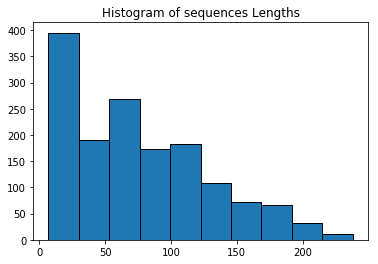

In [5]:
plt.hist(seqLe, edgecolor='black')
myPlotTitle1 = plt.title("Histogram of sequences Lengths")

Ok, we see that the sequences vary in length quite much. It won't concern us much as we only care about the data processing in this notebook.

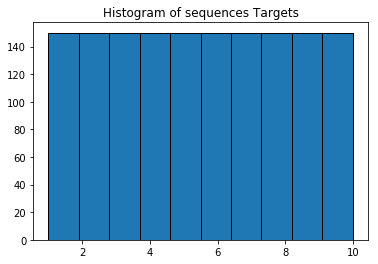

In [6]:
bins_count = len(seqTa[0].unique()) #--- number of unique targets / labels / classes
plt.hist(seqTa, edgecolor='black', bins=bins_count)
myPlotTitle2 = plt.title("Histogram of sequences Targets")

Excellent, someone has done great job - the distribution of sequences is just equal. As we can see , our toy dataset contains 10 classes, each represented by 150 instances.

## Select features

Our data file with toy example (seqTS) has the headers with features names already specified, so we don't have to assign them manually. Therefore we can display some information about our data (utilizing pandas DF methods):

In [7]:
seqTS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115012 entries, 0 to 115011
Data columns (total 6 columns):
sin_alpha    115010 non-null float64
FWHM         115012 non-null float64
max          115012 non-null float64
COG          115012 non-null float64
mean         115012 non-null float64
rel_std      115012 non-null float64
dtypes: float64(6)
memory usage: 5.3 MB


In [8]:
seqTS.describe()

,sin_alpha,FWHM,max,COG,mean,rel_std
count,115010.000000,115012.000000,115012.000000,115012.000000,115012.000000,115012.000000
mean,0.189855,1.722653,0.957423,0.052655,0.457149,0.357484
std,0.250218,0.789514,0.623580,1.309181,0.418220,0.520235
min,0.000000,0.010000,0.112090,-3.500000,0.029815,-1.937600
25%,0.026835,1.333275,0.517185,-0.565482,0.209060,0.103880
50%,0.079323,1.599900,0.832215,0.063689,0.361605,0.385605
75%,0.240570,2.000600,1.168500,0.745090,0.539617,0.617283
max,1.000000,6.510000,3.600000,3.500000,4.084500,2.267800


From the info() method we see that there are some missing values (nulls/nans) in the *sin_alpha* feature. Also we see that there are six features in the file and that individual features have different scales (which is bad for your ML model), so the job of cleaning and scaling is necessary.  
Let's also take a look at the histograms of our features:

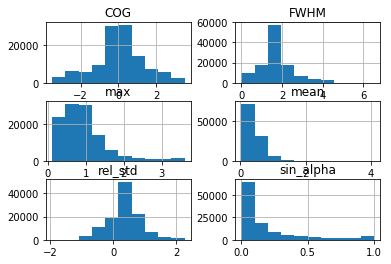

In [9]:
myHistograms = seqTS.hist()

Neural networks like features, which have 0 skewness and which are Normally distributed. To make it happen in our dataset we would have to perform nonlinear operations with different parameters on each of the features. We won't do that as that may brake the relations between values of specific features and confuse the network, so be careful with that.

Now imagine, you would want to test and compare some specific combinations of loaded features. We can create an enum for switching the features subsets conveniently:

In [10]:
class Features(Enum):
    All = 1
    sina_COG_max = 2
    FWHM_COG_std = 3
    sina_mean_std = 4    
    
#--- Let's try the sina_mean_std combination
feat_type = Features.sina_mean_std

So now it is time to implement the selection of a combination of features. We can pass the result to a new DF: seqTSsel (seqTS selected).

In [11]:
if(feat_type == Features.All): #assign all
    seqTSsel = seqTS
if (feat_type == Features.sina_COG_max):
    seqTSsel = seqTS[['sin_alpha','COG','max']]
elif (feat_type == Features.FWHM_COG_std):
    seqTSsel = seqTS[['FWHM', 'COG', 'rel_std']]
elif (feat_type == Features.sina_mean_std):
    seqTSsel = seqTS[['sin_alpha', 'mean', 'rel_std']]    
    
n_inputs = seqTSsel.shape[1]
print("Number of inputs: ",n_inputs)

Number of inputs:  3


According to the setting from the previous cell (feat_type = Features.sina_mean_std) the corresponding option was activated and specific features were selected from the initial seqTS DataFrame. The number of features (inputs to the model) is as expected, we have asked for just three columns.  
I also like to have a variable for the index of column of a new DF (seqTSsel) which would help to avoid unnecessary operations later.

In [12]:
index_sina = seqTSsel.columns.get_loc('sin_alpha') 
index_mean = seqTSsel.columns.get_loc('mean') 
index_std  = seqTSsel.columns.get_loc('rel_std') 
print("sin index: {}, mean index: {}, std index: {}".format(index_sina, index_mean, index_std))

sin index: 0, mean index: 1, std index: 2


## Divide the data - stratified sampling

As pointed at the beginning, at the earliest stage of transformation process, we should divide our set into training, validation and testing sets. In this notebook we will perform the stratified sampling, which, combined with the varied length sequences, may be the source of litte troubles.

The difference between stratified sampling and random sampling is well presented in A. Geron's excellent book [3] as well as in his <a href="https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb">notebook</a>. It allows us to preserve the proportions of the number of elements from individual classes from the whole observation set after sampling into train, valid and test subsets. Or at least with significantly lower error than with just the random sampling.      

Before the acutal sampling we need to:
* specify the ratio between **_training_** , **_valid_** and **_testing_** sets. We assume that the **_valid-ratio_**==**_testing-ratio_** and **_valid-ratio_** = (1-**_training-ratio_**)/2, so let:

In [13]:
training_set_ratio = 0.6

* and transform our stacked sequences (2D data array) into a structure liable to shuffling based upon indicies.

So now it is time to write our first helper function. We need to shuffle three files in this example: data, lengths and targets. We are not able just to merge them as a set of columns as they have different dimensions.  
In order to get all three files in a shuffle friendly form we can take advantage of the fancy property of Python and just use a list. We will extract individual sequences from the seqTSsel DF and append them to a list (as it does not care if we store arrays of different dimensions inside).

In [14]:
def DataToList(sDAT, sLEN): #--- gets DF, DF; returns list

    if(isinstance(sDAT,pd.DataFrame)):
        sDAT=sDAT.as_matrix() #- convert from DF to numpy array
    if(isinstance(sLEN,pd.DataFrame)):
        sLEN=sLEN.as_matrix() #- convert from DF to numpy array
    
    #---here we define start and end indexes of subsequent sequences based upon the vector with lengths
    end_indices   = np.cumsum(sLEN)
    start_indices = np.insert(end_indices[:-1], [0], [0]) #--- first sequence starts from the 0-th line
    myList = []

    for s_ind, e_ind in zip(start_indices, end_indices): #--- each extracted sequence (as array) is appended to our list
        myList.append(sDAT[s_ind : e_ind, :])        

    return myList

So let's run the *DataToList* method and see what we got. We compare the output from the helper method (individual arrays with sequences) with the expected length from the seqLe, for the first 5 examples:

In [15]:
seqS_list = DataToList(seqTSsel, seqLe) # gets DF, DF; returns list
how_many = 5

for index, tmpSeq in enumerate(seqS_list):
    if(index==how_many):
        break
    print("Sequence {0}: Shape of list element (extracted sequence): {1}\t\
           Length of sequence (from the seqLe): {2}".format(index, tmpSeq.shape, seqLe.loc[index][0]))        

Sequence 0: Shape of list element (extracted sequence): (62, 3)	           Length of sequence (from the seqLe): 62
Sequence 1: Shape of list element (extracted sequence): (62, 3)	           Length of sequence (from the seqLe): 62
Sequence 2: Shape of list element (extracted sequence): (198, 3)	           Length of sequence (from the seqLe): 198
Sequence 3: Shape of list element (extracted sequence): (75, 3)	           Length of sequence (from the seqLe): 75
Sequence 4: Shape of list element (extracted sequence): (38, 3)	           Length of sequence (from the seqLe): 38


Great! As we see, the number of rows of each element in the list corresponds perfectly with the expected length.  
To be more sure about the data let's display the *rel_std* feature from these first five elements from the list:

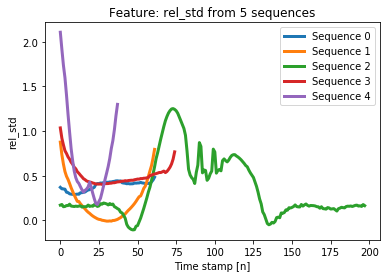

In [16]:
param2display = index_std
for index in range(how_many):
    plt.plot( seqS_list[index][:,param2display], label='Sequence ' + str(index), linewidth=3.0)
    
myPlotTitle3 = plt.title("Feature: {} from {} sequences".format(seqTSsel.columns[param2display], how_many))
plt.legend()
plotXlab = plt.xlabel('Time stamp [n]')
plotYlab = plt.ylabel(seqTSsel.columns[param2display])

You can see that the sequences have varied length (compare them with the results from the previous cell), plots start and finish gently (lines rather don't have unexpected indentations and seem to be continuous) so it really looks that the sequences have been extracted well.

We can also now extract the length of our longest sequence and save it for later before the actual split of data into training, validation and testing sest.

In [17]:
longest_seq = np.max(seqLe.values)

Also it will be more comfortable to use a specified type instead of juggling with many variables so we will use objects of simple helper class.  
It's fields store sequences, targets, legths and the headers of selected features and will be accessed using '.'.

In [18]:
class myDataset:    
    def __init__(self, seqTS, seqTa, seqLe, headers):
        self.seqTS = seqTS
        self.seqTa = seqTa
        self.seqLe = seqLe
        self.headers = headers

Finally we are ready to write first of our main methods, which will handle the stratified sampling itself. As you will see the scikit-learn implements the stratified sampling method (as well as many others) so our duty is only in preparing the data and using the function properly:

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

def DataStratfiedSampling(train_ratio, DataList, seqL, seqT, col_names): #--- gets float, list, DFs; returns myDataset

    tstvld_set_ratio = 1 - train_ratio
    seqT = seqT.as_matrix() #--- DF to np array
    seqL = seqL.as_matrix() #--- DF to np array
    
    #--- split the initial sets into training and just one remaining set (which will be split later);
    #---- notice the test_size param which we define as 1 - train_ratio
    split = StratifiedShuffleSplit(n_splits=1, test_size=tstvld_set_ratio, random_state=16)    
    #--- here we receive two vectors of indices for two sets and create these subsets (np arrays and list)
    for train_index, tstvld_index in split.split(seqL, seqT):
        L_train     = seqL[train_index]
        T_train     = seqT[train_index]
        I_trainLst  = [DataList[i] for i in train_index]

        L_tstvld    = seqL[tstvld_index]
        T_tstvld    = seqT[tstvld_index]
        I_tstvldLst = [DataList[i] for i in tstvld_index]
    
    #--- split the obtained tstvld sets into testing and validation sets;
    #---- notice the test_size param is equal to 0.5 as we want to have test and valid sets of equal size
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=45)    
    #--- here we split the obtained tstvld nps and list into validation and testing set nps and lists
    for test_index, valid_index in split.split(L_tstvld, T_tstvld):
        L_test     = L_tstvld[test_index]
        T_test     = T_tstvld[test_index]
        I_testLst  = [I_tstvldLst[i] for i in test_index]

        L_valid    = L_tstvld[valid_index]
        T_valid    = T_tstvld[valid_index]
        I_validLst = [I_tstvldLst[i] for i in valid_index]

    trainDS = myDataset(I_trainLst, T_train, L_train, seqTSsel.columns)
    validDS = myDataset(I_validLst, T_valid, L_valid, seqTSsel.columns)
    testDS  = myDataset(I_testLst,  T_test,  L_test,  seqTSsel.columns)
     
    return trainDS, validDS, testDS    

So now let's evaluate the method...

In [20]:
trainDS, validDS, testDS =\
    DataStratfiedSampling(training_set_ratio, seqS_list, seqLe, seqTa, seqTSsel.columns) # gets float, list, DFs, returns myDataset

... and see whot we got:

In [21]:
print('Train:\t List length: {0}\tTargets shape: {1}\tLengths shape: {2}'.\
      format(len(trainDS.seqTS), trainDS.seqTa.shape, trainDS.seqLe.shape))
print('Valid:\t List length: {0}\tTargets shape: {1}\tLengths shape: {2}'.\
      format(len(validDS.seqTS), validDS.seqTa.shape, validDS.seqLe.shape))
print('Test: \t List length: {0}\tTargets shape: {1}\tLengths shape: {2}'.\
      format(len(testDS.seqTS), testDS.seqTa.shape, testDS.seqLe.shape))

print('Train set ratio: {0:.4f}'.format(len(trainDS.seqTS)/(len(trainDS.seqTS)+len(validDS.seqTS)+len(testDS.seqTS))))

Train:	 List length: 900	Targets shape: (900, 1)	Lengths shape: (900, 1)
Valid:	 List length: 300	Targets shape: (300, 1)	Lengths shape: (300, 1)
Test: 	 List length: 300	Targets shape: (300, 1)	Lengths shape: (300, 1)
Train set ratio: 0.6000


We have obtained 3 objects with training, validation and test data. The shapes and proportions look as expected. We can also check the labels distribution within the sets:

In [22]:
Tra_distribution = 100*(pd.DataFrame(trainDS.seqTa)[0].value_counts()/len(trainDS.seqTa)).sort_index()
Val_distribution = 100*(pd.DataFrame(validDS.seqTa)[0].value_counts()/len(validDS.seqTa)).sort_index()
Tes_distribution = 100*(pd.DataFrame(testDS.seqTa )[0].value_counts()/len(testDS.seqTa)).sort_index()

expected_percentage = 100*1/bins_count
print('Expected percentage: {0:.5f}% '.format( expected_percentage) )

Tra_error = Tra_distribution - expected_percentage
Val_error = Val_distribution - expected_percentage
Tes_error = Tes_distribution - expected_percentage

summary = pd.concat([pd.DataFrame(Tra_distribution), pd.DataFrame(Val_distribution), pd.DataFrame(Tes_distribution),\
                    Tra_error, Val_error, Tes_error], axis=1)
summary.columns = ['Training [%]', 'Validation [%]','Testing [%]','Tr. error [%]', 'Val. error [%]','Tst. error [%]']
summary

Expected percentage: 10.00000% 


,Training [%],Validation [%],Testing [%],Tr. error [%],Val. error [%],Tst. error [%]
1,10.0,10.0,10.0,0.0,0.0,0.0
2,10.0,10.0,10.0,0.0,0.0,0.0
3,10.0,10.0,10.0,0.0,0.0,0.0
4,10.0,10.0,10.0,0.0,0.0,0.0
5,10.0,10.0,10.0,0.0,0.0,0.0
6,10.0,10.0,10.0,0.0,0.0,0.0
7,10.0,10.0,10.0,0.0,0.0,0.0
8,10.0,10.0,10.0,0.0,0.0,0.0
9,10.0,10.0,10.0,0.0,0.0,0.0
10,10.0,10.0,10.0,0.0,0.0,0.0


Pretty smooth. We have succesfully obtained training, validation and testing sets balanced as our initial dataset.  
So let's clean the data as we know it contains some unwanted values.

## Clean the data (remove nulls)

As we have successfully split the data now it is time to clean it. Just before that it could be useful to provide a list of manual replacements for some of the null/NANs in our data. For example, we may have detected that in the preprocessing stage our function for calculation of sin(x) returned null instead of 0.  
So let's create a list of tuples **feature_name-value** and we will take care of it very soon.

In [23]:
ManualCleanList = [] 
ManualCleanList.append( ('sina', 0.0) )    # (feature name, value to be placed instead of null)

And just take a look that in this case nulls are present in our training set (69159 non_null sin_alpha rows instead of 69161):

In [24]:
pd.DataFrame(np.vstack(trainDS.seqTS), columns=trainDS.headers).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69161 entries, 0 to 69160
Data columns (total 3 columns):
sin_alpha    69159 non-null float64
mean         69161 non-null float64
rel_std      69161 non-null float64
dtypes: float64(3)
memory usage: 1.6 MB


OK, so finally, here comes another of our main functions.

In [25]:
from sklearn.preprocessing import Imputer

def CleanData(trainDS, validDS, testDS, ManualCleanList):  #--- gets myDatasets, List; returns myDatasets
    
    #- We extract our data arrays from myDataset objects and stack them as we have to investigate each feature globally
    # Conversion to a DF object is also performed as it will be helpful for taking care of individual features
    Itrain = pd.DataFrame(np.vstack(trainDS.seqTS), columns=trainDS.headers)
    Itest  = pd.DataFrame(np.vstack(validDS.seqTS), columns=validDS.headers)
    Ivalid = pd.DataFrame(np.vstack(testDS.seqTS),  columns=testDS.headers)

    #- with these 2 lines, utilizing imputer, a median value of each feature from the training set is calculated
    imputer = Imputer(strategy="median")
    imputer.fit(Itrain)

    #- each feature has now it's median, which will substitute any null (if present) from a corresponding feature column
    #- or, as pointed above, we may want not to use a median but some other value, so we have to tell it to the imputer:
    for _, (param_name, value) in enumerate(ManualCleanList):            
        if(param_name in Itrain.columns):
            spec_index = Itrain.columns.get_loc(param_name)                        
            imputer.statistics_[spec_index] = value                

    #- With lines below come the actual (possible) replacement. Note that the median was evaluated only on the training set 
    # but will be utilized to replace nulls in other sets as well
    Itrain = imputer.transform(Itrain)    
    Ivalid = imputer.transform(Ivalid)    
    Itest  = imputer.transform(Itest)    

    # and before leaving the method it would be good to pack the transformed data back in to our myDataset objects
    trainDS.seqTS = DataToList(Itrain, trainDS.seqLe)
    validDS.seqTS = DataToList(Ivalid, validDS.seqLe)
    testDS.seqTS  = DataToList(Itest,  testDS.seqLe)
    
    return trainDS, validDS, testDS

In [26]:
trainDS, validDS, testDS = CleanData(trainDS, validDS, testDS, ManualCleanList) # gets myDataset; returns myDataset

So the data is clean. There were not many missing values in our datasets but you may compare the output of info() method on our myDataset objects before and after application of the *CleanData* method:

In [27]:
pd.DataFrame(np.vstack(trainDS.seqTS), columns=seqTSsel.columns).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69161 entries, 0 to 69160
Data columns (total 3 columns):
sin_alpha    69161 non-null float64
mean         69161 non-null float64
rel_std      69161 non-null float64
dtypes: float64(3)
memory usage: 1.6 MB


## Data scaling
It is also strongly adviced to scale the range of input features to make all of them in the same range. For that the last of our main methods comes:

In [28]:
from sklearn import preprocessing

def DataNormalization(trainDS, validDS, testDS):  #--- gets myDatasets; returns myDatasets
        
    #- We extract our data arrays from myDataset objects and stack them as we have to investigate each feature globally
    Itrain = np.vstack(trainDS.seqTS)
    Ivalid = np.vstack(validDS.seqTS)
    Itest  = np.vstack(testDS.seqTS)    

    # scikit-learn comes with a method for removing the mean and scaling by standard deviation at once, 
    # note that taking the referential values also has to be done with respect to our training set only.
    std_scale = preprocessing.StandardScaler().fit(Itrain)
    train_set = std_scale.transform(Itrain)
    valid_set = std_scale.transform(Ivalid)
    test_set  = std_scale.transform(Itest)    

    # before leaving the method we pack the transformed data back in to our myDataset objects
    trainDS.seqTS = DataToList(train_set, trainDS.seqLe)
    validDS.seqTS = DataToList(valid_set, validDS.seqLe)
    testDS.seqTS  = DataToList(test_set,  testDS.seqLe)
    
    return trainDS, validDS, testDS

So let's evaluate this method and immediately after display the effect:

,sin_alpha,mean,rel_std
count,6.916100e+04,6.916100e+04,6.916100e+04
mean,1.380792e-16,-4.561544e-17,-6.739579e-17
std,1.000007e+00,1.000007e+00,1.000007e+00
min,-7.533933e-01,-1.010648e+00,-3.925651e+00
25%,-6.474371e-01,-5.885939e-01,-4.933395e-01
50%,-4.418191e-01,-2.344977e-01,5.980500e-02
75%,1.925030e-01,1.858252e-01,4.896237e-01
max,3.265882e+00,8.538727e+00,3.635472e+00


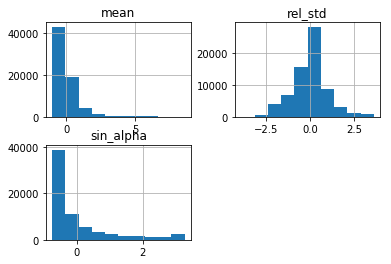

In [29]:
trainDS, validDS, testDS = DataNormalization(trainDS, validDS, testDS) # gets myDatasets; returns myDatasets
Itrain = pd.DataFrame(np.vstack(trainDS.seqTS), columns=trainDS.headers) # pack data into DF
Itrain.hist()
Itrain.describe()

Note how the mean value (which is technically 0 for all features) has changed as well as the standard deviation, which is now 1 (these indicate that normalization was succesful). From the histogram of rel_std we see that it's distribution is almost Normal. For Normal distributions you can think of dividing the data by 3 (not 1) std to obtain the output range of the feature close to <-1,1>.  
  
So let's display the same informations for one of remaining sets (e.g. valid) to see that it was also transformed properly. We can see that the mean and standard deviation are not as close to 0 and 1 as it was for the training set but this is the effect of new data.

,sin_alpha,mean,rel_std
count,22763.000000,22763.000000,22763.000000
mean,0.036512,-0.038801,-0.039232
std,1.023388,0.917924,0.965083
min,-0.753393,-1.001460,-3.598118
25%,-0.642990,-0.582047,-0.476572
50%,-0.414592,-0.237936,-0.017376
75%,0.270979,0.162545,0.448391
max,3.265882,8.175328,3.635472


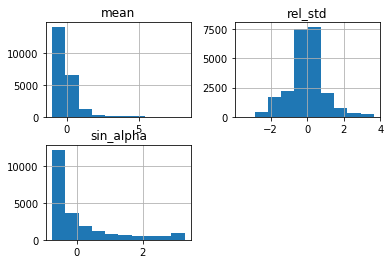

In [30]:
Ivalid = pd.DataFrame(np.vstack(validDS.seqTS), columns=validDS.headers) # pack data into DF
Ivalid.hist()
Ivalid.describe()

Brilliant. We are done with the whole pipeline! The only thing left is to save the effect of our transformations. Why not to write another two helper methods for this purpose:

In [31]:
def SaveToCsv(dataMatrix, dataType, suffix):
    _path = 'data/'
    stackedData = np.vstack(dataMatrix)   
    tempDataFrame = pd.DataFrame(stackedData)
    tempDataFrame.to_csv(_path + dataType+suffix+'.csv', index=False, header=False, decimal=',', sep=';')    

In [32]:
def MySaver(myDatasetObject, dataType):
    SaveToCsv(myDatasetObject.seqTS, dataType, 'TS')
    SaveToCsv(myDatasetObject.seqTa, dataType, 'Ta')
    SaveToCsv(myDatasetObject.seqLe, dataType, 'Le')            

...and evaluate them:

In [33]:
dataset_tp = 'FEAT'

MySaver(trainDS,'train'+dataset_tp)
MySaver(validDS,'valid'+dataset_tp)
MySaver(testDS, 'test' +dataset_tp)

With that, 9 new .csv files in total were saved. There are 3 for each of training, validation, testing sets (with stacked sequences, lengths and targets).

---
#### References  
[1] http://scikit-learn.org/stable/modules/pipeline.html  
[2] https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb  
[3] A. Geron - _"Hands-On Machine Learning with Scikit-Learn & TensorFlow"_